In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob

def read_table_with_header_to_numpy(file_path):
    with open(file_path, 'r') as file:
        header = file.readline().strip()
        data = [list(map(float, line.strip().split())) for line in file if line.strip()]
    return np.array(data), header

# === File Paths ===
base_path = "/mnt/em_data/vishal/data/11042025_BR_normal/auto"
file_indices = range(689, 699)  # Files from 0000000689 to 0000000698
file_paths = [f"{base_path}/0000000{idx}/APH/image_ctfcor_unbent_with_resolution.aph" for idx in file_indices]

# === Read All Tables ===
tables_with_headers = [read_table_with_header_to_numpy(fp) for fp in file_paths]
tables = [tbl for tbl, hdr in tables_with_headers]
headers = [hdr for tbl, hdr in tables_with_headers]

# === Extract Resolution and Amplitude Columns ===
resolutions = [table[:, 6] for table in tables]
amplitudes = [table[:, 2] for table in tables]




Results saved to: /home/vikumar/analysis_data/11042025_BR_normal/2


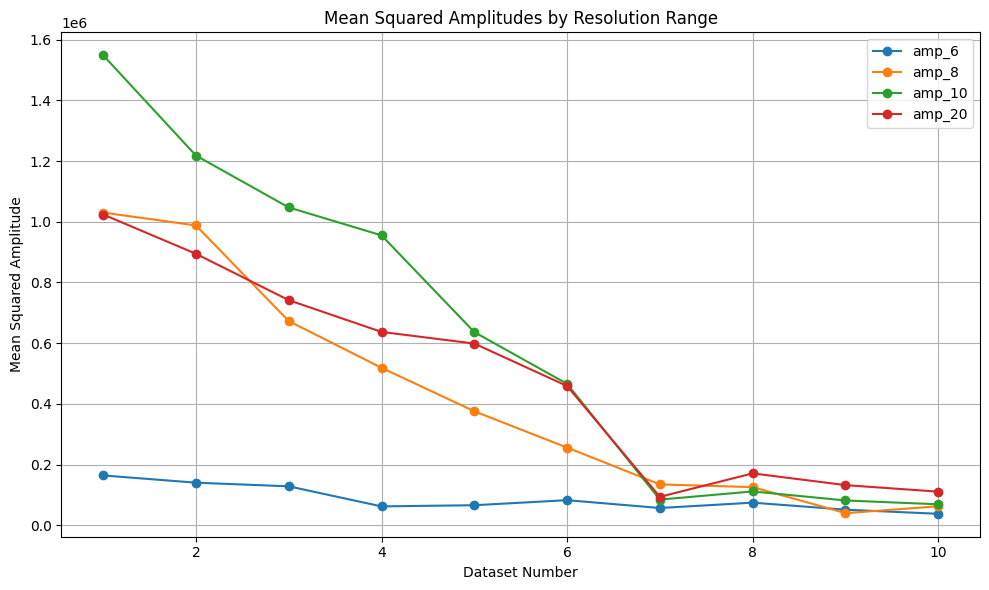

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

def filter_and_store_mean_amplitudes(resolution_dict, amplitude_dict, output_dir, ranges=None):
    """
    Filters amplitudes based on specified resolution ranges, computes squared mean values,
    and saves them to disk.

    Parameters:
    - resolution_dict (dict): Keys like 'resolution1', values are arrays.
    - amplitude_dict (dict): Keys like 'amplitude1', values are arrays.
    - output_dir (str): Where to save the mean values.
    - ranges (dict): Resolution bins. Default: amp_6, amp_8, amp_10, amp_20.

    Returns:
    - dict: {range_name: [mean1, mean2, ...]} for all datasets.
    """
    if ranges is None:
        ranges = {
            "amp_6": (6, 7),
            "amp_8": (7, 9),
            "amp_10": (9, 12),
            "amp_20": (12, 35)
        }

    os.makedirs(output_dir, exist_ok=True)
    mean_processed = {name: [] for name in ranges}

    for dataset_key, res in resolution_dict.items():
        amp_key = dataset_key.replace("resolution", "amplitude")

        if amp_key not in amplitude_dict:
            print(f"Warning: {amp_key} not found. Skipping...")
            continue

        amp = amplitude_dict[amp_key]
        

        for range_name, (low, high) in ranges.items():
            mask = (res > low) & (res <= high)
            filtered = amp[mask]
            filtered = filtered[filtered > 0]  # Ignore zero or negative
            filtered = np.square(filtered)
            mean_val = np.mean(filtered) if filtered.size > 0 else np.nan
            mean_processed[range_name].append(mean_val)

    # Save to files
    for range_name, means in mean_processed.items():
        out_path = os.path.join(output_dir, f"{range_name}.txt")
        np.savetxt(out_path, means, fmt="%.6f", header=f"Mean squared amplitudes for {range_name}")

    print(f"Results saved to: {output_dir}")
    return mean_processed

# === Usage ===
resolution_data = {f"resolution{i}": res for i, res in enumerate(resolutions, start=1)}
amplitude_data = {f"amplitude{i}": amp for i, amp in enumerate(amplitudes, start=1)}

output_directory = "/home/vikumar/analysis_data/11042025_BR_normal/2"
mean_processed_amplitudes = filter_and_store_mean_amplitudes(resolution_data, amplitude_data, output_directory)

# === Plotting ===
plt.figure(figsize=(10, 6))
for range_name, values in mean_processed_amplitudes.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=range_name)

plt.xlabel("Dataset Number")
plt.ylabel("Mean Squared Amplitude")
plt.title("Mean Squared Amplitudes by Resolution Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
